# SMA Lab 15: Exploring Marketing Campaign dataset

In [1]:
import numpy as np 
import pandas as pd

In [2]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Reading a Source File
data = pd.read_csv("marketing.csv")

In [5]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [6]:
data.rename(columns={'MntWines': 'Wines',
                     'MntFruits': 'Fruits',
                     'MntMeatProducts': 'Meat',
                     'MntFishProducts': 'Fish',
                     'MntSweetProducts': 'Sweet',
                     'MntGoldProds': 'Gold',
                     'NumDealsPurchases': 'Discount_Purchases',
                     'NumWebPurchases': 'Web_Purchases',
                     'NumCatalogPurchases': 'Catalog_Purchases',
                     'NumStorePurchases': 'Store_Purchases'}, inplace=True)

In [7]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,Wines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [8]:
le = LabelEncoder()
education_label = le.fit_transform(data['Education'])
data['Education'] = education_label

In [9]:
marital_staus_label = le.fit_transform(data['Marital_Status'])
data['Marital_Status'] = marital_staus_label

In [10]:
data[['Z_CostContact', 'Z_Revenue']].describe()

,Z_CostContact,Z_Revenue
count,2240.0,2240.0
mean,3.0,11.0
std,0.0,0.0
min,3.0,11.0
25%,3.0,11.0
50%,3.0,11.0
75%,3.0,11.0
max,3.0,11.0


In [11]:
data.drop(columns=['Z_CostContact', 'Z_Revenue'], inplace=True)

In [12]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], dayfirst=True)

data['Day'] = data['Dt_Customer'].apply(lambda x: x.day)
data['Month'] = data['Dt_Customer'].apply(lambda x: x.month)
data['Year'] = data['Dt_Customer'].apply(lambda x: x.year)

data.drop(columns='Dt_Customer', inplace=True)

In [13]:
mean_income = round(data.groupby('Education')['Income'].mean(), 2)
data['Income'] = data.apply(lambda row: mean_income[row['Education']] 
                        if np.isnan(row['Income']) 
                        else row['Income'], axis=1)

In [14]:
# amount the customer spent on all product categories in the last 2 years
data['Total_Products'] = data['Wines'] + data['Fruits'] + data['Meat'] + \
                         data['Fish'] + data['Sweet'] + data['Gold']

In [16]:
# number of accepted offers for all campaigns
data['Total_Accepted'] = data['AcceptedCmp1'] + data['AcceptedCmp2'] + \
                         data['AcceptedCmp3'] + data['AcceptedCmp4'] + data['AcceptedCmp5']

In [17]:
# number of customer purchases
data['Total_Purchases'] = data['Discount_Purchases'] + data['Web_Purchases'] + \
                        data['Catalog_Purchases'] + data['Store_Purchases']

In [18]:
# number of children
data['Children'] = data['Kidhome'] + data['Teenhome']

In [19]:
# is the client a parent or not (1 - yes, 0 - no)
data['Parents'] = np.where(data['Children'] > 0, 1, 0)

In [20]:
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Wines,Fruits,...,Complain,Response,Day,Month,Year,Total_Products,Total_Accepted,Total_Purchases,Children,Parents
0,5524,1957,2,4,58138.0,0,0,58,635,88,...,0,1,4,9,2012,1617,0,25,0,0
1,2174,1954,2,4,46344.0,1,1,38,11,1,...,0,0,8,3,2014,27,0,6,2,1
2,4141,1965,2,5,71613.0,0,0,26,426,49,...,0,0,21,8,2013,776,0,21,0,0
3,6182,1984,2,5,26646.0,1,0,26,11,4,...,0,0,10,2,2014,53,0,8,1,1
4,5324,1981,4,3,58293.0,1,0,94,173,43,...,0,0,19,1,2014,422,0,19,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,2,3,61223.0,0,1,46,709,43,...,0,0,13,6,2013,1341,0,18,1,1
2236,4001,1946,4,5,64014.0,2,1,56,406,0,...,0,0,10,6,2014,444,1,22,3,1
2237,7270,1981,2,2,56981.0,0,0,91,908,48,...,0,0,25,1,2014,1241,1,19,0,0
2238,8235,1956,3,5,69245.0,0,1,8,428,30,...,0,0,24,1,2014,843,0,23,1,1


In [21]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [24]:
pip install kneed

Defaulting to user installation because normal site-packages is not writeable



In [25]:
from kneed import KneeLocator

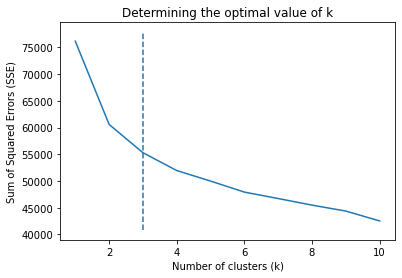

Optimal number of clusters (k): 3


In [26]:
# determining the optimal value of K
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)
    
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
optimal_k = kl.elbow

# result visualization
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Determining the optimal value of k')
plt.plot(range(1, 11), sse)
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

print("Optimal number of clusters (k):", optimal_k)

In [27]:
# client clustering with K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_scaled)
data['Cluster'] = kmeans.labels_

In [28]:
# Analyze the resulting groups/clusters
cluster_sizes = data['Cluster'].value_counts()

In [29]:
# Let's see how many clients are in each group/cluster
for cluster in range(3):
    print(f"Group {cluster} contains {cluster_sizes[cluster]} clients")

Group 0 contains 514 clients
Group 1 contains 1070 clients
Group 2 contains 656 clients


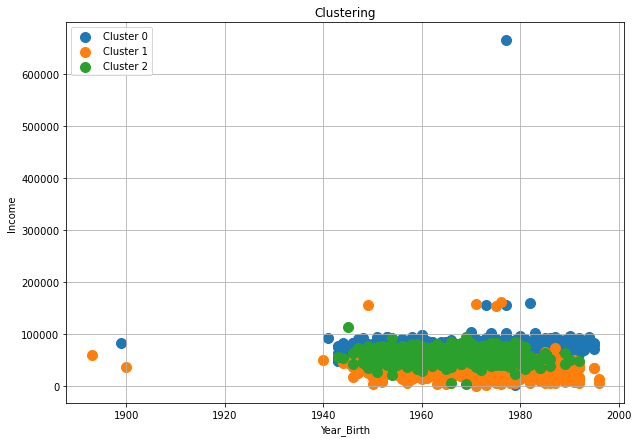

In [30]:
fig, ax = plt.subplots(figsize=(10, 7))  
legend = []
x_lable='Year_Birth'
y_lable='Income'
ax.set_xlabel(x_lable)             
ax.set_ylabel(y_lable)  
plt.title('Clustering')
for c, rows in data.groupby('Cluster'):
    plt.scatter(rows[x_lable], rows[y_lable], s = 100)
    legend.append("Cluster %s" % c)
plt.legend(legend, loc="upper left")
plt.grid()
plt.show()

In [31]:
data.shape

(2240, 35)

In [32]:
# remove noise
data = data[(data['Year_Birth'] > 1900) & (data['Income'] < 600_000)]

In [33]:
data.shape

(2236, 35)

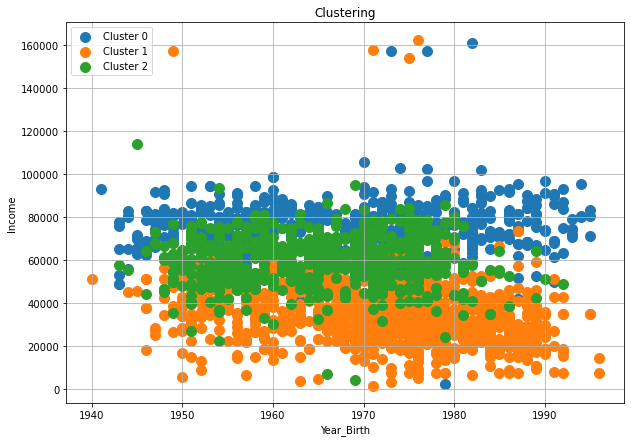

In [34]:
fig, ax = plt.subplots(figsize=(10, 7))  
legend = []
x_lable='Year_Birth'
y_lable='Income'
ax.set_xlabel(x_lable)             
ax.set_ylabel(y_lable)  
plt.title('Clustering')
for c, rows in data.groupby('Cluster'):
    plt.scatter(rows[x_lable], rows[y_lable], s = 100)
    legend.append("Cluster %s" % c)
plt.legend(legend, loc="upper left")
plt.grid()
plt.show()

In [35]:
cluster_means = data.groupby('Cluster').mean()
cluster_means

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,Wines,Fruits,...,Complain,Response,Day,Month,Year,Total_Products,Total_Accepted,Total_Purchases,Children,Parents
Cluster,,,,,,,,,,,,,,,,,,,,,
0,5684.662109,1968.515625,2.423828,3.765625,76328.001211,0.023438,0.042969,49.095703,631.882812,64.107422,...,0.005859,0.330078,15.386719,6.437500,2013.039062,1408.406250,0.826172,20.341797,0.066406,0.064453
1,5601.800562,1971.338951,2.281835,3.722846,35565.028642,0.780899,0.459738,49.289326,45.155431,5.022472,...,0.011236,0.088951,15.815543,6.282772,2013.124532,102.617978,0.082397,8.086142,1.240637,0.877341
2,5493.525915,1965.222561,2.557927,3.711890,59661.036021,0.224085,0.945122,48.850610,469.937500,31.350610,...,0.007622,0.106707,15.533537,6.786585,2012.861280,799.216463,0.236280,21.652439,1.169207,0.958841


In [36]:
# scale data after removing noise
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [37]:
# splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_scaled[:, :-1], 
                                                    data_scaled[:, -1], 
                                                    test_size=0.2, 
                                                    random_state=42)

In [38]:
# model training
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [39]:
# prediction on the test set
y_pred = model.predict(X_test)

In [40]:
# evaluation of the quality of the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('RMS error:', round(mse, 3))
print('R^2 score:', round(r2, 3))

RMS error: 0.295
R^2 score: 0.703


In [41]:
# separate train and test data
X_train, X_test, y_train, y_test = train_test_split(data.drop("Cluster", axis=1), 
                                                    data["Cluster"],
                                                    test_size=0.2,
                                                    random_state=42)

In [42]:
# scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [43]:
# train the model
model = LGBMRegressor()
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2164
[LightGBM] [Info] Number of data points in the train set: 1788, number of used features: 33
[LightGBM] [Info] Start training from score 1.069351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor()

In [44]:
# Predict on test set
y_pred = model.predict(X_test)

In [45]:
# Assess the quality of the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMS error:", round(mse, 3))
print("R^2 Score:", round(r2, 3))

RMS error: 0.069
R^2 Score: 0.866


In [46]:
data.shape

(2236, 35)

In [47]:
pd.DataFrame(data={'features': data.drop(columns='Cluster').columns, 
                   'importances': model.feature_importances_}).sort_values(by='importances', 
                                                                           ascending=False).head(10)

,features,importances
29,Total_Products,280
4,Income,251
8,Wines,227
12,Sweet,194
11,Fish,187
10,Meat,186
9,Fruits,145
13,Gold,137
31,Total_Purchases,120
15,Web_Purchases,113


In [48]:
# Defining the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'num_leaves': [10, 20, 30]
}

In [49]:
# Selection of hyperparameters using GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2118
[LightGBM] [Info] Number of data points in the train set: 1430, number of used features: 33
[LightGBM] [Info] Start training from score 1.074126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2117
[LightGBM] [Info] Number of data points in the train set: 1430, number of used features: 33
[LightGBM] [Info] Start training from score 1.077622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2108
[LightGBM] [Info] Number of data points in the train set: 1430, number of used features: 33
[LightGBM] [Info] Start traini

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'num_leaves': [10, 20, 30]},
             scoring='neg_mean_squared_error')

In [50]:
# Display results
print("Best params:", grid_search.best_params_)
print("Best score:", round(-grid_search.best_score_, 3))

Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 30}
Best score: 0.063


In [51]:
# Assessing model quality on test data
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMS error:", round(mse, 3))
print("R^2 score:", round(r2, 3))

RMS error: 0.071
R^2 score: 0.862
